In [15]:
import pandas as pd
import os
import numpy as np
import ast
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import requests
import time
import os, glob
from scipy.stats import ttest_ind
import ast

In [19]:
def get_lung_data(output_dir, metadata_path):
    os.makedirs(output_dir, exist_ok=True)
    # Define the base URL for the GDC API
    url = "https://api.gdc.cancer.gov/files"

    # Define the filters for the gene expression data for bronchus and lung cancer
    filters = {
        "op": "and",
        "content": [
            {
                "op": "in",
                "content": {
                    "field": "cases.primary_site",
                    "value": ["bronchus and lung"]
                }
            },
            {
                "op": "in",
                "content": {
                    "field": "files.experimental_strategy",
                    "value": ["RNA-Seq"]
                }
            },
            {
                "op": "in",
                "content": {
                    "field": "files.data_type",
                    "value": ["Gene Expression Quantification"]
                }
            }
        ]
    }

    # Parameters for the GDC API request
    params = {
        "filters": filters,
        "size": "1000",  # Max number of files per page
        "fields": (
            "file_id,file_name,cases.case_id,"
            "cases.samples.sample_id,cases.samples.sample_type"
        ),
        "format": "json"
    }

    # Initialize list to store all file metadata
    all_files = []

    # Pagination control variables
    current_page = 1
    more_results = True

    print("Fetching file metadata for all gene expression data for lung and bronchus...")

    # Loop through pages of results
    while more_results:
        print(f"Fetching page {current_page}...")
        response = requests.post(url, json=params)
        response.raise_for_status() 
        data = response.json()

        # Add the retrieved files to the list
        files = data["data"]["hits"]
        all_files.extend(files)

        # Check if there are more results
        if len(files) < int(params["size"]):
            more_results = False  
        else:
            # Use pagination to get the next page
            current_page += 1
            params["from"] = len(all_files)  

        # Delay between requests to avoid overwhelming the server
        time.sleep(1)

    print(f"Total files fetched: {len(all_files)}")

    # Convert to a DataFrame for easier handling
    file_data = pd.json_normalize(all_files)
    print(file_data.head())

    # Save metadata to a CSV file for reference
#     metadata_file = os.path.join(output_dir, metadata_path)
    file_data.to_csv(metadata_path, index=False)
    print(f"Metadata saved to {metadata_path}")

    # Download each file by file_id
    print("Downloading gene expression files...")
    for i, file_info in enumerate(file_data.itertuples(), 1):
        file_id = file_info.file_id
        file_name = file_info.file_name
        file_path = os.path.join(output_dir, f"{file_name}.tar.gz")

        if os.path.exists(file_path.rsplit('.', 2)[0]):
            print('already exists.')
            continue

        download_url = f"https://api.gdc.cancer.gov/data/{file_id}"

        try:
            # Make the request to download the file
            response = requests.get(download_url, headers={"Content-Type": "application/json"})
            response.raise_for_status()

            # Save the file
            with open(file_path, "wb") as f:
                f.write(response.content)

            print(f"[{i}/{len(file_data)}] Downloaded: {file_name}")

        except requests.exceptions.RequestException as e:
            print(f"Error downloading file {file_id}: {e}")

    print("All gene expression files downloaded successfully!")

    # Rename downloaded files from .tar.gz to .tsv
    for file_path in glob.glob(os.path.join(output_dir, "*.tsv.tar.gz")):
        new_file_path = file_path.replace(".tsv.tar.gz", ".tsv")
        os.rename(file_path, new_file_path)
        print(f"Renamed: {file_path} -> {new_file_path}")

        
        
# def process_expression_files(folder_path, output_file):
#     """
#     Processes all RNA-Seq expression files in the given folder:
#     - Removes the first 5 rows.
#     - Extracts the case ID from the filename.
#     - Adds a new 'case_id' column.
#     - Concatenates all files into a single DataFrame.
#     - Saves the final DataFrame to a CSV file.

#     Args:
#         folder_path (str): Path to the folder containing expression files.
#         output_file (str): Path to save the concatenated CSV file.
#     """
#     all_dfs = []

#     print(f"Processing RNA-Seq expression files in folder: {folder_path}")

#     # Loop through all files in the folder
#     for file_name in os.listdir(folder_path):
#         if file_name.endswith(".tsv"):  # Only process .tsv files
#             file_path = os.path.join(folder_path, file_name)

#             # Extract case_id from the filename (before the first '.')
#             filename = file_name.split(".")[0]
#             try:
#                 #print(f"Processing file: {file_name} (case_id: {case_id})")
#                 # Read the file into a DataFrame, skipping the first 5 rows since we don't need them
#                 df = pd.read_csv(file_path, sep="\t", skiprows=5)

#                 # Add the case_id column
#                 df['file_name'] = filename

#                 # Append the DataFrame to the list
#                 all_dfs.append(df)
#             except:
#                 print(f'Error: could not process file {file_name}')
#                 continue

#     # Concatenate all DataFrames
#     combined_df = pd.concat(all_dfs, ignore_index=True)
#     print('Combined all expression data')
#     # Save the combined DataFrame to a CSV file
#     combined_df.to_csv(output_file, index=False)
#     print(f"All expression files processed and saved to: {output_file}")

#     # Return the combined DataFrame
#     return combined_df


def process_expression_files_chunked(input_folder_path, output_file):
    """
    Processes RNA-Seq expression files in the given folder:
    - Removes the first 5 rows.
    - Extracts the case ID from the filename.
    - Adds a new 'file_name' column.
    - Writes files incrementally to avoid memory overload.

    Args:
        input_folder_path (str): Path to the folder containing expression files.
        output_file (str): Path to save the concatenated CSV file.
    """
    # Open output file in write mode
    with open(output_file, mode='w', newline='', encoding='utf-8') as outfile:
        first_file = True  # Flag to indicate the first file
        print(f"Processing RNA-Seq expression files in folder: {input_folder_path}")

        # Loop through all files in the folder
        for file_name in os.listdir(input_folder_path):
            if file_name.endswith(".tsv"):  # Only process .tsv files
                file_path = os.path.join(input_folder_path, file_name)

                # Extract file_name from the filename
                filename = file_name.split(".")[0]

                try:
                    # Read the file, skipping the first 5 rows
                    df = pd.read_csv(file_path, sep="\t", skiprows=5)

                    # Add the 'file_name' column
                    df['file_name'] = filename

                    # Write to the output file
                    if first_file:
                        # Write header for the first file
                        df.to_csv(outfile, index=False, mode='w')
                        first_file = False
                    else:
                        # Append without header for subsequent files
                        df.to_csv(outfile, index=False, header=False, mode='a')

                except Exception as e:
                    print(f"Error processing file {file_name}: {e}")
                    continue

    print(f"All expression files processed and saved to: {output_file}")

In [17]:
output_dir = "TCGA_LungBronchus_Gene_Expression"
os.makedirs('metadata', exist_ok=True)
metadata_path = "metadata/expression_file_metadata.csv"

In [18]:
#download the gene expression data files, along with the metadata file mapping identifiers for each file
get_lung_data(output_dir, metadata_path)

Fetching file metadata for all gene expression data for lung and bronchus...
Fetching page 1...
Fetching page 2...
Fetching page 3...
Total files fetched: 2042
                                     id  \
0  0da74bba-de0a-4583-acc9-5f5e0a4ad0a4   
1  65b87b34-fca0-4ffe-853e-1edf2cee7bbe   
2  c67f194f-0c71-4835-801c-5b6da7a583ef   
3  4236170e-67b4-4bd7-badd-4fcba557d0e3   
4  7da3a15e-9911-4429-98e7-d7ee03d7ad7f   

                                               cases  \
0  [{'case_id': '8808123c-50cc-4111-9552-5c2c1cbd...   
1  [{'case_id': '58d6a27e-07d1-4adb-81a2-a7fe6588...   
2  [{'case_id': 'dbece124-c042-4adc-8136-90e7940e...   
3  [{'case_id': 'dbece124-c042-4adc-8136-90e7940e...   
4  [{'case_id': 'acae4e48-57de-40c5-9ae5-4386144e...   

                                           file_name  \
0  87a06489-4b88-4fe1-8896-0cf7d23a901a.rna_seq.a...   
1  18f974d7-d1e0-4e4f-95ff-bbc61a4ce1ab.rna_seq.a...   
2  4c84a3bd-3b6f-4627-a4d9-acd3b9669608.rna_seq.a...   
3  6df80c92-775e-4bc

Error downloading file 670fd5f9-55ef-4224-b0a9-f3316c3f0f4d: 451 Client Error: UNAVAILABLE FOR LEGAL REASONS for url: https://api.gdc.cancer.gov/data/670fd5f9-55ef-4224-b0a9-f3316c3f0f4d
already exists.
already exists.
Error downloading file 3f72eaf8-5d81-4eb4-bdb0-73fc854c995e: 403 Client Error: FORBIDDEN for url: https://api.gdc.cancer.gov/data/3f72eaf8-5d81-4eb4-bdb0-73fc854c995e
Error downloading file 81fe7328-48e2-4e02-84a6-146ffbeeeb19: 403 Client Error: FORBIDDEN for url: https://api.gdc.cancer.gov/data/81fe7328-48e2-4e02-84a6-146ffbeeeb19
Error downloading file cabc9743-8f16-4a00-9686-c8ab1b383496: 403 Client Error: FORBIDDEN for url: https://api.gdc.cancer.gov/data/cabc9743-8f16-4a00-9686-c8ab1b383496
Error downloading file 09aad55f-3945-429d-a6e1-4d6c05180b73: 403 Client Error: FORBIDDEN for url: https://api.gdc.cancer.gov/data/09aad55f-3945-429d-a6e1-4d6c05180b73
Error downloading file 62fed7ed-1207-4047-ad19-91f5aede1eb6: 403 Client Error: FORBIDDEN for url: https://api.gdc

In [20]:
# Process the gex files and get the concatenated DataFrame
output_file = "all_lung_expression_data.csv"
process_expression_files_chunked(output_dir, output_file)

Processing RNA-Seq expression files in folder: TCGA_LungBronchus_Gene_Expression
All expression files processed and saved to: all_lung_expression_data.csv


In [7]:
# load locally saved concatenated data 
lung_expression_df = pd.read_csv("all_lung_expression_data.csv")
lung_expression_df.head()

,N_ambiguous,Unnamed: 1,Unnamed: 2,6573131,1607836,1601048,Unnamed: 6,Unnamed: 7,Unnamed: 8,file_name
0,ENSG00000000003.15,TSPAN6,protein_coding,3206,1609,1597,35.3085,11.5325,12.8167,f6091416-01d7-45d0-9bec-2a84cfdcc413
1,ENSG00000000005.6,TNMD,protein_coding,0,0,0,0.0000,0.0000,0.0000,f6091416-01d7-45d0-9bec-2a84cfdcc413
2,ENSG00000000419.13,DPM1,protein_coding,2900,1437,1463,120.0272,39.2035,43.5689,f6091416-01d7-45d0-9bec-2a84cfdcc413
3,ENSG00000000457.14,SCYL3,protein_coding,647,616,616,4.6959,1.5338,1.7046,f6091416-01d7-45d0-9bec-2a84cfdcc413
4,ENSG00000000460.17,C1orf112,protein_coding,613,600,645,5.1295,1.6754,1.8620,f6091416-01d7-45d0-9bec-2a84cfdcc413


In [21]:
# fix column names (that got messed up by skipping first 5 rows)

lung_expression_df = lung_expression_df.rename(columns={'N_ambiguous' : 'gene_id', 
                                                        'Unnamed: 1' : 'gene_name',
                                                       'Unnamed: 2' : 'gene_type',
                                                        '6573131' : 'unstranded',
                                                        '1607836' : 'stranded_first',
                                                        '1601048' : 'stranded_second',
                                                        'Unnamed: 6' : 'tpm_unstranded',
                                                        'Unnamed: 7' : 'fpkm_unstranded',
                                                        'Unnamed: 8' : 'fpkm_uq_unstranded'
                                                       })

lung_expression_df.head()

,gene_id,gene_name,gene_type,unstranded,stranded_first,stranded_second,tpm_unstranded,fpkm_unstranded,fpkm_uq_unstranded,file_name
0,ENSG00000000003.15,TSPAN6,protein_coding,3206,1609,1597,35.3085,11.5325,12.8167,f6091416-01d7-45d0-9bec-2a84cfdcc413
1,ENSG00000000005.6,TNMD,protein_coding,0,0,0,0.0000,0.0000,0.0000,f6091416-01d7-45d0-9bec-2a84cfdcc413
2,ENSG00000000419.13,DPM1,protein_coding,2900,1437,1463,120.0272,39.2035,43.5689,f6091416-01d7-45d0-9bec-2a84cfdcc413
3,ENSG00000000457.14,SCYL3,protein_coding,647,616,616,4.6959,1.5338,1.7046,f6091416-01d7-45d0-9bec-2a84cfdcc413
4,ENSG00000000460.17,C1orf112,protein_coding,613,600,645,5.1295,1.6754,1.8620,f6091416-01d7-45d0-9bec-2a84cfdcc413


In [22]:
# drop duplicates and unnecessary columns 

lung_expression_df = lung_expression_df.drop_duplicates()
lung_tpm_df = lung_expression_df.drop(columns=['unstranded', 'stranded_first', 'stranded_second', 'fpkm_unstranded', 'fpkm_uq_unstranded'])
lung_tpm_df.head()

,gene_id,gene_name,gene_type,tpm_unstranded,file_name
0,ENSG00000000003.15,TSPAN6,protein_coding,35.3085,f6091416-01d7-45d0-9bec-2a84cfdcc413
1,ENSG00000000005.6,TNMD,protein_coding,0.0000,f6091416-01d7-45d0-9bec-2a84cfdcc413
2,ENSG00000000419.13,DPM1,protein_coding,120.0272,f6091416-01d7-45d0-9bec-2a84cfdcc413
3,ENSG00000000457.14,SCYL3,protein_coding,4.6959,f6091416-01d7-45d0-9bec-2a84cfdcc413
4,ENSG00000000460.17,C1orf112,protein_coding,5.1295,f6091416-01d7-45d0-9bec-2a84cfdcc413


In [47]:
def process_and_normalize(
    input_file, 
    normalize_columns=None, 
    explode_column=None
):
    """
    General-purpose function to process and normalize JSON-like columns in a DataFrame.

    Args:
        input_file (str): Path to the input CSV file.
        normalize_columns (dict, optional): Dictionary where keys are column names to normalize,
                                            and values are prefixes for the normalized columns.
                                            Example: {"cases": "cases", "diagnoses": "diagnoses"}.
        explode_column (str, optional): Name of the column to explode into multiple rows.

    Returns:
        pd.DataFrame: Processed and normalized DataFrame.
    """
    # Read the input file
    df = pd.read_csv(input_file)
    

    # Normalize specified columns
    if normalize_columns:
        for col, prefix in normalize_columns.items():
            # Safely evaluate stringified JSON objects (if any)
            df[col] = df[col].apply(
                lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith("[") else x
            )
            # Flatten the JSON-like data
            normalized_data = pd.json_normalize(df[col].dropna().explode())
            # Add prefixes to new columns
            normalized_data.columns = [f"{prefix}.{sub_col}" for sub_col in normalized_data.columns]
            # Merge normalized data
            df = pd.concat([df.reset_index(drop=True), normalized_data.reset_index(drop=True)], axis=1)
            # Drop original column
            df = df.drop(columns=[col])

    # Explode a column into multiple rows if specified
    if explode_column:
        df = df.explode(explode_column)
        # Handle missing values in the column
        df[explode_column] = df[explode_column].fillna({})
        # Normalize the exploded column
        expanded_data = pd.json_normalize(df[explode_column])
        # Add prefixes to expanded columns
        expanded_data.columns = [f"{explode_column}.{col}" for col in expanded_data.columns]
        # Merge expanded data
        df = pd.concat([df.reset_index(drop=True), expanded_data.reset_index(drop=True)], axis=1)
        # Drop exploded column
        df = df.drop(columns=[explode_column])
            

    return df


case_sample_metadata = process_and_normalize(
    input_file='metadata/expression_file_metadata.csv',
    normalize_columns={"cases": "cases"},
    explode_column="cases.samples"
)

case_sample_metadata['file_name'] = case_sample_metadata['file_name'].apply(lambda x: x.split(".")[0])

case_sample_metadata.head()

,id,file_name,file_id,cases.case_id,cases.samples.sample_id,cases.samples.sample_type
0,0da74bba-de0a-4583-acc9-5f5e0a4ad0a4,87a06489-4b88-4fe1-8896-0cf7d23a901a,0da74bba-de0a-4583-acc9-5f5e0a4ad0a4,8808123c-50cc-4111-9552-5c2c1cbd2da0,8c556ab0-5393-498a-a3c6-9dd05738c003,Primary Tumor
1,65b87b34-fca0-4ffe-853e-1edf2cee7bbe,18f974d7-d1e0-4e4f-95ff-bbc61a4ce1ab,65b87b34-fca0-4ffe-853e-1edf2cee7bbe,58d6a27e-07d1-4adb-81a2-a7fe6588458c,5e5d64f4-7086-41ab-b676-1dc1e8e8f8b9,Primary Tumor
2,c67f194f-0c71-4835-801c-5b6da7a583ef,4c84a3bd-3b6f-4627-a4d9-acd3b9669608,c67f194f-0c71-4835-801c-5b6da7a583ef,dbece124-c042-4adc-8136-90e7940ee6ad,92c7c076-1ae8-4672-a58f-7a4e6cc10e47,Solid Tissue Normal
3,4236170e-67b4-4bd7-badd-4fcba557d0e3,6df80c92-775e-4bcf-b2c7-6cbd7e147447,4236170e-67b4-4bd7-badd-4fcba557d0e3,dbece124-c042-4adc-8136-90e7940ee6ad,f714cd57-39e0-46bf-a35a-988c574f75a1,Primary Tumor
4,7da3a15e-9911-4429-98e7-d7ee03d7ad7f,ef697db7-3b14-4999-9e9b-85c37718f615,7da3a15e-9911-4429-98e7-d7ee03d7ad7f,acae4e48-57de-40c5-9ae5-4386144ebaea,d926c859-1348-4dab-ac0e-4e4cde393664,Primary Tumor


In [25]:
# merge to get in the gex file : case_id, sample_id and sample_type. 
#case_id will be needed for further merging with clinical metadata(demographic, diagnostic, exposure and treatment info)
# sample level info is used in current EDA and visual analysis. 

lung_df = pd.merge(lung_tpm_df, case_sample_metadata, on='file_name')
lung_df.head()

,gene_id,gene_name,gene_type,tpm_unstranded,file_name,id,file_id,cases.case_id,cases.samples.sample_id,cases.samples.sample_type
0,ENSG00000000003.15,TSPAN6,protein_coding,35.3085,f6091416-01d7-45d0-9bec-2a84cfdcc413,6590155e-5fe1-460a-8ed3-a4d8516d55b2,6590155e-5fe1-460a-8ed3-a4d8516d55b2,86b165c2-d0e6-4a4f-84ed-aa95e3133627,d254d457-f42f-42a1-88ff-1e05158c554e,Primary Tumor
1,ENSG00000000005.6,TNMD,protein_coding,0.0000,f6091416-01d7-45d0-9bec-2a84cfdcc413,6590155e-5fe1-460a-8ed3-a4d8516d55b2,6590155e-5fe1-460a-8ed3-a4d8516d55b2,86b165c2-d0e6-4a4f-84ed-aa95e3133627,d254d457-f42f-42a1-88ff-1e05158c554e,Primary Tumor
2,ENSG00000000419.13,DPM1,protein_coding,120.0272,f6091416-01d7-45d0-9bec-2a84cfdcc413,6590155e-5fe1-460a-8ed3-a4d8516d55b2,6590155e-5fe1-460a-8ed3-a4d8516d55b2,86b165c2-d0e6-4a4f-84ed-aa95e3133627,d254d457-f42f-42a1-88ff-1e05158c554e,Primary Tumor
3,ENSG00000000457.14,SCYL3,protein_coding,4.6959,f6091416-01d7-45d0-9bec-2a84cfdcc413,6590155e-5fe1-460a-8ed3-a4d8516d55b2,6590155e-5fe1-460a-8ed3-a4d8516d55b2,86b165c2-d0e6-4a4f-84ed-aa95e3133627,d254d457-f42f-42a1-88ff-1e05158c554e,Primary Tumor
4,ENSG00000000460.17,C1orf112,protein_coding,5.1295,f6091416-01d7-45d0-9bec-2a84cfdcc413,6590155e-5fe1-460a-8ed3-a4d8516d55b2,6590155e-5fe1-460a-8ed3-a4d8516d55b2,86b165c2-d0e6-4a4f-84ed-aa95e3133627,d254d457-f42f-42a1-88ff-1e05158c554e,Primary Tumor


In [26]:
# file name and file id are mapped 1 to 1, we dont need both identifiers so remove file_id. Also remove id which appears to be identical to file_id

lung_df = lung_df.drop(columns=['id', 'file_id']) 
lung_df.head()

,gene_id,gene_name,gene_type,tpm_unstranded,file_name,cases.case_id,cases.samples.sample_id,cases.samples.sample_type
0,ENSG00000000003.15,TSPAN6,protein_coding,35.3085,f6091416-01d7-45d0-9bec-2a84cfdcc413,86b165c2-d0e6-4a4f-84ed-aa95e3133627,d254d457-f42f-42a1-88ff-1e05158c554e,Primary Tumor
1,ENSG00000000005.6,TNMD,protein_coding,0.0000,f6091416-01d7-45d0-9bec-2a84cfdcc413,86b165c2-d0e6-4a4f-84ed-aa95e3133627,d254d457-f42f-42a1-88ff-1e05158c554e,Primary Tumor
2,ENSG00000000419.13,DPM1,protein_coding,120.0272,f6091416-01d7-45d0-9bec-2a84cfdcc413,86b165c2-d0e6-4a4f-84ed-aa95e3133627,d254d457-f42f-42a1-88ff-1e05158c554e,Primary Tumor
3,ENSG00000000457.14,SCYL3,protein_coding,4.6959,f6091416-01d7-45d0-9bec-2a84cfdcc413,86b165c2-d0e6-4a4f-84ed-aa95e3133627,d254d457-f42f-42a1-88ff-1e05158c554e,Primary Tumor
4,ENSG00000000460.17,C1orf112,protein_coding,5.1295,f6091416-01d7-45d0-9bec-2a84cfdcc413,86b165c2-d0e6-4a4f-84ed-aa95e3133627,d254d457-f42f-42a1-88ff-1e05158c554e,Primary Tumor


In [27]:
# Pivot the DataFrame to get gex data in wide format
# Note: we use gene_id here, and not gene_name, because the same gene_name can have multiple isoforms (represented by gene_id)

wide_lung_df = lung_df.pivot_table(
    index=['cases.case_id', 'file_name', 'cases.samples.sample_id', 'cases.samples.sample_type'], 
    columns='gene_id', 
    values='tpm_unstranded', 
    aggfunc='first' # there are no duplicates with this indexing anyway
)

# Reset index to make the result easier to read
wide_lung_df = wide_lung_df.reset_index()
wide_lung_df.head()

gene_id,cases.case_id,file_name,cases.samples.sample_id,cases.samples.sample_type,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.13,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,...,ENSG00000288661.1,ENSG00000288662.1,ENSG00000288663.1,ENSG00000288665.1,ENSG00000288667.1,ENSG00000288669.1,ENSG00000288670.1,ENSG00000288671.1,ENSG00000288674.1,ENSG00000288675.1
0,003f4f85-3244-4132-8c9d-c29f09382269,514aa2ae-6c49-4b89-9a44-0f87a80bf77f,ca05dbf9-803c-4019-b79c-1a6c5a9d85d5,Primary Tumor,13.3969,0.0000,44.1675,10.6373,5.7801,9.5199,...,0.0,6.1276,0.1843,0.0,38.7460,0.0000,7.3537,0.0,0.0273,0.5002
1,003f4f85-3244-4132-8c9d-c29f09382269,d09e76b4-f980-4b9c-a9e1-e97b60e26950,63824d8d-425b-4ec8-ae7e-16920db41523,Solid Tissue Normal,9.9742,0.3680,59.1509,12.5600,3.9517,58.4894,...,0.0,40.0951,0.4221,0.0,64.8815,0.0000,8.8898,0.0,0.0726,0.3695
2,005669e5-1a31-45fb-ae97-9d450e74e7cb,6a994238-296a-4047-a8d4-e2eed5dd7bfc,a007ecae-0f53-4523-a9b3-8865ed7cf614,Primary Tumor,47.9405,0.0000,208.1272,7.8144,8.1576,7.8835,...,0.0,0.0000,0.5409,0.0,0.0000,0.0000,15.0961,0.0,0.0160,1.0091
3,006931bb-f5b1-4aa4-b0a8-af517a912db0,f9806a31-d0e2-4bea-858b-3934067ba2f4,675fc17b-5328-4c29-80dc-8ca6749e7db5,Primary Tumor,24.4524,0.2799,82.1127,8.7390,3.9551,11.2927,...,0.0,34.4337,0.1554,0.0,34.8369,0.0148,5.6187,0.0,0.0307,0.4568
4,0075437e-ba1a-46be-86d6-9773209a2b5e,0a4e0b83-7afa-475b-8586-e9e79e31d6d2,9ab03618-703c-4401-a198-e02510807646,Primary Tumor,66.6188,0.0000,62.7215,6.4699,6.4174,7.7751,...,0.0,0.0000,0.5954,0.0,0.0000,0.0000,14.6692,0.0,0.0441,0.4208


In [28]:
#Check for anomaly: are there more than 1 sample_ids associated with the same file_name in the data?

sample_counts_per_file = wide_lung_df.groupby(['file_name', 'cases.samples.sample_type'])['cases.samples.sample_id'].nunique()

# # Filter rows where more than one sample_id is associated with the same file_name
multiple_cases = pd.DataFrame(sample_counts_per_file[sample_counts_per_file > 1]).reset_index()

multiple_cases

,file_name,cases.samples.sample_type,cases.samples.sample_id
0,0245dddc-1b8b-499e-bb1f-3e4fdcc92ed9,Primary Tumor,2
1,05c9a666-3e80-4d01-b2a8-d889ea4c0ab0,Primary Tumor,2
2,0ddbbf5c-24ab-400f-bff6-04c19b986227,Primary Tumor,2
3,0e0691d9-27b9-45b3-a857-40eeb3134e9b,Primary Tumor,2
4,11f78118-17ce-4047-a4a9-cec6e8afbe89,Primary Tumor,2
...,...,...,...
83,f2b5ad42-a662-4aa1-98c8-6a33a8483887,Primary Tumor,2
84,f5abc0fb-5b5c-44f5-85cd-0ec631a42eb9,Primary Tumor,2
85,f6aaf704-ebc5-43b1-8d86-dc7590bd3313,Primary Tumor,2
86,f8d63768-e9eb-4b1e-b344-b19985e3fe9e,Primary Tumor,2


In [29]:
# For those rows having same file_name but multiple sample_ids: check which columns are different 

for file_name in multiple_cases.file_name.unique().tolist():
#     print(f'For file {file_name}')
    
    # Get all rows corresponding to this file_name
    file_rows = wide_lung_df[wide_lung_df['file_name'] == file_name]
    
    # Get the number of duplicates (unique sample IDs for this file)
    num_duplicates = len(file_rows['cases.samples.sample_id'].unique())
#     print(f'Number of duplicates (sample IDs): {num_duplicates}')
    
    # Compare rows pairwise
    for i in range(len(file_rows) - 1):
        for j in range(i + 1, len(file_rows)):
            row1 = file_rows.iloc[i]
            row2 = file_rows.iloc[j]

            # Find columns where the values differ
            differences = row1 != row2
            diff_columns = differences[differences].index
            
            if diff_columns.any():  # If there are any differences
#                 print(f"Difference between rows {i} and {j}:")
#                 print(f"Columns with differences: {diff_columns.tolist()}")
                
                # Display the values in the differing columns
                diff_values = pd.DataFrame({'Row_1': row1[diff_columns], 'Row_2': row2[diff_columns]})
            
                if diff_columns.tolist() != ['cases.samples.sample_id']:
                    print(f'For file {file_name}')
                    print(f'Number of duplicates (sample IDs): {num_duplicates}')
                    display(diff_values)
                    
# it seems that sample_id is the only difference and all gene expression values are same
# i.e. we have multiple sample IDs representing the same exact file, sample, gex values. we will simply treat them as duplicates.

In [30]:
# Drop duplicates based on all columns except 'sample_id'
deduplicated_lung_df = wide_lung_df.drop_duplicates(subset=wide_lung_df.columns.difference(['sample_id']))

print(f"Original df shape: {wide_lung_df.shape}")
print(f"Deduplicated df shape: {deduplicated_lung_df.shape}")

Original df shape: (2106, 60664)
Deduplicated df shape: (2106, 60664)


In [31]:
deduplicated_lung_df.head()

gene_id,cases.case_id,file_name,cases.samples.sample_id,cases.samples.sample_type,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.13,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,...,ENSG00000288661.1,ENSG00000288662.1,ENSG00000288663.1,ENSG00000288665.1,ENSG00000288667.1,ENSG00000288669.1,ENSG00000288670.1,ENSG00000288671.1,ENSG00000288674.1,ENSG00000288675.1
0,003f4f85-3244-4132-8c9d-c29f09382269,514aa2ae-6c49-4b89-9a44-0f87a80bf77f,ca05dbf9-803c-4019-b79c-1a6c5a9d85d5,Primary Tumor,13.3969,0.0000,44.1675,10.6373,5.7801,9.5199,...,0.0,6.1276,0.1843,0.0,38.7460,0.0000,7.3537,0.0,0.0273,0.5002
1,003f4f85-3244-4132-8c9d-c29f09382269,d09e76b4-f980-4b9c-a9e1-e97b60e26950,63824d8d-425b-4ec8-ae7e-16920db41523,Solid Tissue Normal,9.9742,0.3680,59.1509,12.5600,3.9517,58.4894,...,0.0,40.0951,0.4221,0.0,64.8815,0.0000,8.8898,0.0,0.0726,0.3695
2,005669e5-1a31-45fb-ae97-9d450e74e7cb,6a994238-296a-4047-a8d4-e2eed5dd7bfc,a007ecae-0f53-4523-a9b3-8865ed7cf614,Primary Tumor,47.9405,0.0000,208.1272,7.8144,8.1576,7.8835,...,0.0,0.0000,0.5409,0.0,0.0000,0.0000,15.0961,0.0,0.0160,1.0091
3,006931bb-f5b1-4aa4-b0a8-af517a912db0,f9806a31-d0e2-4bea-858b-3934067ba2f4,675fc17b-5328-4c29-80dc-8ca6749e7db5,Primary Tumor,24.4524,0.2799,82.1127,8.7390,3.9551,11.2927,...,0.0,34.4337,0.1554,0.0,34.8369,0.0148,5.6187,0.0,0.0307,0.4568
4,0075437e-ba1a-46be-86d6-9773209a2b5e,0a4e0b83-7afa-475b-8586-e9e79e31d6d2,9ab03618-703c-4401-a198-e02510807646,Primary Tumor,66.6188,0.0000,62.7215,6.4699,6.4174,7.7751,...,0.0,0.0000,0.5954,0.0,0.0000,0.0000,14.6692,0.0,0.0441,0.4208


In [32]:
# remove columns where all values are 0. (either the gene was not considered or the expression value was too low to be picked up)

all_zero_columns = deduplicated_lung_df.columns[(deduplicated_lung_df == 0).all()].tolist()
print(len(all_zero_columns))

filt_lung_df = deduplicated_lung_df.drop(columns = all_zero_columns)

2378


In [33]:
# Value counts of tissue sample types present in the data 

filt_lung_df['cases.samples.sample_type'].value_counts()

cases.samples.sample_type
Primary Tumor                            1632
Solid Tissue Normal                       449
Metastatic                                 14
Next Generation Cancer Model                6
Recurrent Tumor                             2
Expanded Next Generation Cancer Model       1
Slides                                      1
Not Reported                                1
Name: count, dtype: int64

In [34]:
# save the wide-format gex file with clinical covariates 

# filt_lung_df.to_csv('wide_lung_gex_clinical.csv')

In [35]:
# For the remaining analysis in this notebook, we focus only on primary tumour and normal solid tissues

filt_lung_df = filt_lung_df[filt_lung_df['cases.samples.sample_type'].isin(['Primary Tumor', 'Solid Tissue Normal'])]
filt_lung_df.head()

gene_id,cases.case_id,file_name,cases.samples.sample_id,cases.samples.sample_type,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.13,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,...,ENSG00000288658.1,ENSG00000288659.1,ENSG00000288660.1,ENSG00000288662.1,ENSG00000288663.1,ENSG00000288667.1,ENSG00000288669.1,ENSG00000288670.1,ENSG00000288674.1,ENSG00000288675.1
0,003f4f85-3244-4132-8c9d-c29f09382269,514aa2ae-6c49-4b89-9a44-0f87a80bf77f,ca05dbf9-803c-4019-b79c-1a6c5a9d85d5,Primary Tumor,13.3969,0.0000,44.1675,10.6373,5.7801,9.5199,...,0.6373,0.0,0.2167,6.1276,0.1843,38.7460,0.0000,7.3537,0.0273,0.5002
1,003f4f85-3244-4132-8c9d-c29f09382269,d09e76b4-f980-4b9c-a9e1-e97b60e26950,63824d8d-425b-4ec8-ae7e-16920db41523,Solid Tissue Normal,9.9742,0.3680,59.1509,12.5600,3.9517,58.4894,...,0.0000,0.0,0.1067,40.0951,0.4221,64.8815,0.0000,8.8898,0.0726,0.3695
2,005669e5-1a31-45fb-ae97-9d450e74e7cb,6a994238-296a-4047-a8d4-e2eed5dd7bfc,a007ecae-0f53-4523-a9b3-8865ed7cf614,Primary Tumor,47.9405,0.0000,208.1272,7.8144,8.1576,7.8835,...,0.7792,0.0,0.0000,0.0000,0.5409,0.0000,0.0000,15.0961,0.0160,1.0091
3,006931bb-f5b1-4aa4-b0a8-af517a912db0,f9806a31-d0e2-4bea-858b-3934067ba2f4,675fc17b-5328-4c29-80dc-8ca6749e7db5,Primary Tumor,24.4524,0.2799,82.1127,8.7390,3.9551,11.2927,...,0.3780,0.0,0.0000,34.4337,0.1554,34.8369,0.0148,5.6187,0.0307,0.4568
4,0075437e-ba1a-46be-86d6-9773209a2b5e,0a4e0b83-7afa-475b-8586-e9e79e31d6d2,9ab03618-703c-4401-a198-e02510807646,Primary Tumor,66.6188,0.0000,62.7215,6.4699,6.4174,7.7751,...,0.2621,0.0,0.0000,0.0000,0.5954,0.0000,0.0000,14.6692,0.0441,0.4208


## T-testing all genes for tumour v/s normal tissue groups

In [36]:
# Subset the data by sample type
tumor_data = filt_lung_df[filt_lung_df['cases.samples.sample_type'] == 'Primary Tumor']
normal_data = filt_lung_df[filt_lung_df['cases.samples.sample_type'] == 'Solid Tissue Normal']

gene_columns = filt_lung_df.columns[4:]  # Skip metadata columns

# Check which gene columns are missing in either tumor or normal data
missing_in_tumor = [gene for gene in gene_columns if gene not in tumor_data.columns]
missing_in_normal = [gene for gene in gene_columns if gene not in normal_data.columns]

# Print missing columns
print("Missing in tumor data:", len(missing_in_tumor))
print("Missing in normal data:", len(missing_in_normal))

print(f"Num rows tumor data: {len(tumor_data)}")
print(f"Num rows normal data: {len(normal_data)}")

# Filter out missing genes from both tumor_data and normal_data
common_genes = [gene for gene in gene_columns if gene in tumor_data.columns and gene in normal_data.columns]

# Perform t-test only on common genes
p_values = {}
for gene in common_genes:
    t_stat, p_val = ttest_ind(tumor_data[gene], normal_data[gene], nan_policy='omit')
    p_values[gene] = p_val

# Convert to DataFrame for easy viewing
p_value_df = pd.DataFrame(p_values.items(), columns=['Gene', 'p_value'])
p_value_df['Significant'] = p_value_df['p_value'] < 0.05  # Set threshold for significance

p_value_df

Missing in tumor data: 0
Missing in normal data: 0
Num rows tumor data: 1632
Num rows normal data: 449


,Gene,p_value,Significant
0,ENSG00000000003.15,1.222344e-58,True
1,ENSG00000000005.6,5.139943e-01,False
2,ENSG00000000419.13,1.598248e-31,True
3,ENSG00000000457.14,2.470158e-01,False
4,ENSG00000000460.17,3.044186e-52,True
...,...,...,...
58277,ENSG00000288667.1,8.152957e-87,True
58278,ENSG00000288669.1,3.349840e-01,False
58279,ENSG00000288670.1,4.131070e-06,True
58280,ENSG00000288674.1,1.089014e-41,True


In [31]:
p_value_df['Significant'].value_counts()

Significant
True     41668
False    16614
Name: count, dtype: int64

## Measuring the log fold change of the genes

Log2 Fold Change (logFC) = 1:

This corresponds to a fold change of 2. Specifically:
log2(2)=1

A logFC of 1 means that the **gene's expression in the tumor sample is 2 times greater than in the normal sample**

/var/folders/xr/b__dtky94kv9txzqq5nvxq8h0000gn/T/ipykernel_42036/1378210948.py:8: RuntimeWarning: divide by zero encountered in log2
  logFC[gene] = np.log2(tumor_mean / normal_mean)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


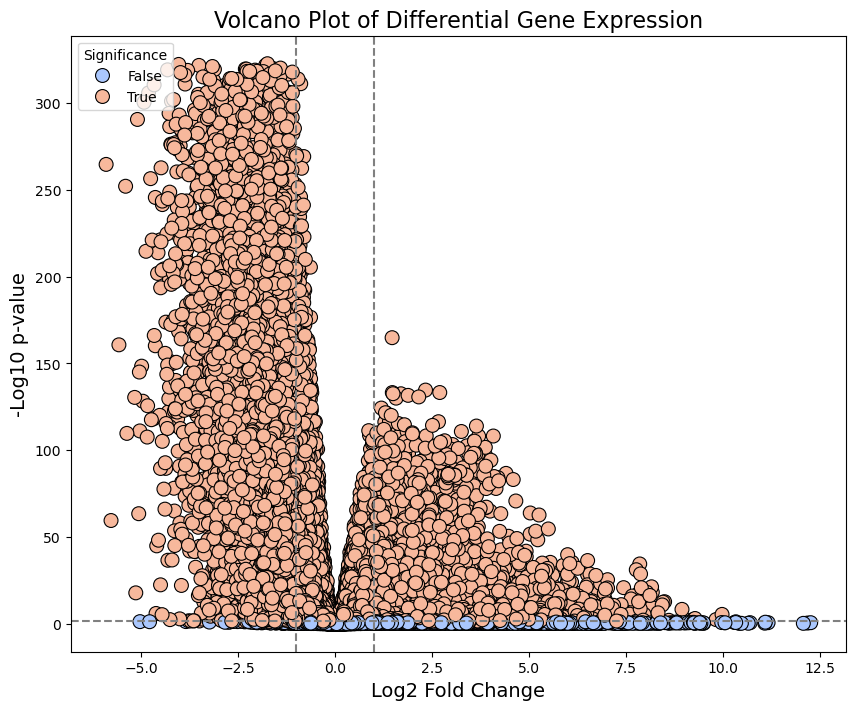

In [37]:
# Calculate log2 fold change

logFC = {}
for gene in p_value_df['Gene']:
    tumor_mean = tumor_data[gene].mean()
    normal_mean = normal_data[gene].mean()
    if normal_mean > 0:
        logFC[gene] = np.log2(tumor_mean / normal_mean)

# Add log2 fold change to p_value_df
p_value_df['logFC'] = p_value_df['Gene'].map(logFC)

# Compute -log10(p-value)
p_value_df['-log10(p-value)'] = -np.log10(p_value_df['p_value'])

# Set thresholds for significance
logFC_threshold = 1  # for example, fold change > 2 or < -2
p_value_threshold = 0.05  # significance level

# Create the volcano plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=p_value_df, x='logFC', y='-log10(p-value)', hue='Significant', palette='coolwarm', s=100, edgecolor='k')

# Add horizontal and vertical lines to highlight the thresholds
plt.axhline(y=-np.log10(p_value_threshold), color='grey', linestyle='--')
plt.axvline(x=logFC_threshold, color='grey', linestyle='--')
plt.axvline(x=-logFC_threshold, color='grey', linestyle='--')

plt.title('Volcano Plot of Differential Gene Expression', fontsize=16)
plt.xlabel('Log2 Fold Change', fontsize=14)
plt.ylabel('-Log10 p-value', fontsize=14)
plt.legend(title='Significance', loc='upper left')

plt.show()


In [38]:
#selecting genes based on the results of t-tests and logFC


logFC_threshold = 1  # Absolute log2 fold change > 1 (fold change > 2 or < 0.5)
p_value_threshold = 0.05  

# condition to identify significant genes
p_value_df['Significant'] = (
    (p_value_df['logFC'].abs() > logFC_threshold) & 
    (p_value_df['p_value'] < p_value_threshold)
)

# Filter for significant genes
significant_genes = p_value_df[p_value_df['Significant']]

# Sort by log fold change or -log10(p-value) for further prioritization
prioritized_genes = significant_genes.sort_values(by='logFC', ascending=False)

# save for downstream analysis
# prioritized_genes.to_csv('prioritized_genes.csv', index=False)

In [113]:
prioritized_genes.head(30)

,Gene,p_value,Significant,logFC,-log10(p-value)
31517,ENSG00000234262.1,4.247769e-06,True,9.971458,5.371839
6574,ENSG00000132446.7,4.071037e-03,True,9.815666,2.390295
34919,ENSG00000240386.3,9.620893e-04,True,9.274533,3.016785
16065,ENSG00000185962.1,4.037229e-03,True,9.231260,2.393917
2003,ENSG00000094796.5,7.990013e-03,True,9.078632,2.097452
16283,ENSG00000186847.6,5.361759e-09,True,8.938703,8.270693
36943,ENSG00000248195.1,1.066019e-02,True,8.601144,1.972235
12570,ENSG00000169469.9,2.093564e-13,True,8.490708,12.679114
16279,ENSG00000186832.9,4.004865e-13,True,8.449764,12.397412
37518,ENSG00000249116.1,1.488010e-11,True,8.429617,10.827394


In [116]:
# get info on the top most differentially expressed genes 

def get_gene_name(ensembl_id):
    url = f"https://rest.ensembl.org/lookup/id/{ensembl_id}?content-type=application/json"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        return {
            "gene_name": data.get("display_name", "N/A"),
            "description": data.get("description", "No description available"),
            "biotype": data.get("biotype", "N/A"),
            "species": data.get("species", "N/A")
        }
    else:
        return {"error": "Gene ID not found or Ensembl service unavailable."}

In [124]:
# get info for the top 10 genes

top_genes = prioritized_genes['Gene'][:10].tolist()
top_genes = [gene_id.split('.')[0] for gene_id in top_genes]

for gene_id in top_genes:
    print(gene_id)
    gene_info = get_gene_name(gene_id)
    print(gene_info)

ENSG00000234262
{'gene_name': 'N/A', 'description': 'small proline-rich protein 3 (SPRR3) pseudogene', 'biotype': 'transcribed_unprocessed_pseudogene', 'species': 'homo_sapiens'}
ENSG00000132446
{'gene_name': 'FTHL17', 'description': 'ferritin heavy chain like 17 [Source:HGNC Symbol;Acc:HGNC:3987]', 'biotype': 'protein_coding', 'species': 'homo_sapiens'}
ENSG00000240386
{'gene_name': 'LCE1F', 'description': 'late cornified envelope 1F [Source:HGNC Symbol;Acc:HGNC:29467]', 'biotype': 'protein_coding', 'species': 'homo_sapiens'}
ENSG00000185962
{'gene_name': 'LCE3A', 'description': 'late cornified envelope 3A [Source:HGNC Symbol;Acc:HGNC:29461]', 'biotype': 'protein_coding', 'species': 'homo_sapiens'}
ENSG00000094796
{'gene_name': 'KRT31', 'description': 'keratin 31 [Source:HGNC Symbol;Acc:HGNC:6448]', 'biotype': 'protein_coding', 'species': 'homo_sapiens'}
ENSG00000186847
{'gene_name': 'KRT14', 'description': 'keratin 14 [Source:HGNC Symbol;Acc:HGNC:6416]', 'biotype': 'protein_coding', 

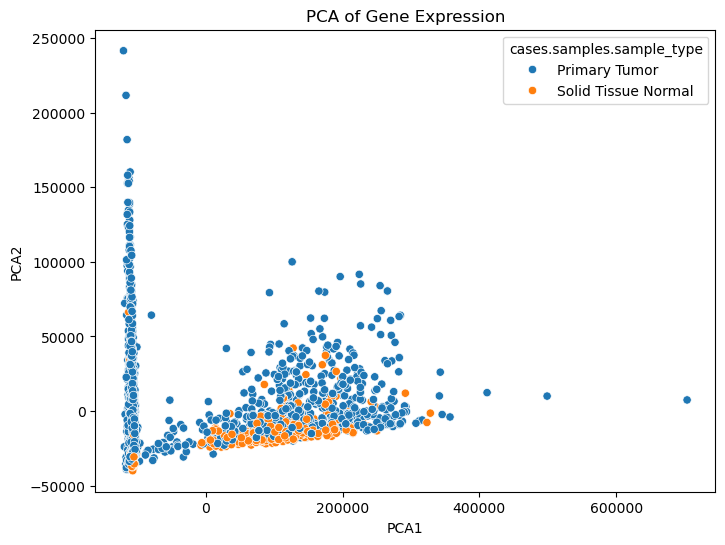

In [39]:
pca_df = filt_lung_df.copy(deep=True)

# Perform PCA on gene expression data
pca = PCA(n_components=2)
pca_results = pca.fit_transform(pca_df[gene_columns].values)

# Add PCA components to the DataFrame
pca_df.loc[:, 'PCA1'] = pca_results[:, 0]
pca_df.loc[:, 'PCA2'] = pca_results[:, 1]

# Scatter plot of PCA results, colored by sample type
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='cases.samples.sample_type', data=pca_df)
plt.title("PCA of Gene Expression")
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

#todo: visualize diff cancer diagnoses in this

In [36]:
import pandas as pd
import numpy as np
import plotly.express as px

# Create the heatmap data (subset of genes)
heatmap_data = filt_lung_df[gene_columns]

# Set sample_id as the index
heatmap_data.index = filt_lung_df['cases.samples.sample_id']

# Add prefixes to the sample_ids in the index (N_ for normal, T_ for tumor)
heatmap_data.index = ['N_' + str(sample_id) if sample_type == 'Solid Tissue Normal' 
                      else 'T_' + str(sample_id) 
                      for sample_id, sample_type in zip(filt_lung_df['cases.samples.sample_id'], filt_lung_df['cases.samples.sample_type'])]

# Calculate the variance of gene expression for each gene (column-wise)
gene_variance = heatmap_data.var()

# Select the top 100 genes with the highest variance
top_genes = gene_variance.nlargest(100).index
heatmap_data_subset = heatmap_data[top_genes]

# Log-transform the data
heatmap_data_subset_log = np.log2(heatmap_data_subset + 1)  # Adding 1 to avoid log(0)

# Separate the normal and tumor samples
normal_samples = filt_lung_df[filt_lung_df['cases.samples.sample_type'] == 'Solid Tissue Normal']
tumor_samples = filt_lung_df[filt_lung_df['cases.samples.sample_type'] == 'Primary Tumor']

# Add prefixes to sample_ids for normal and tumor samples
normal_samples_ids = ['N_' + str(sample_id) for sample_id in normal_samples['cases.samples.sample_id']]
tumor_samples_ids = ['T_' + str(sample_id) for sample_id in tumor_samples['cases.samples.sample_id']]

# Reorder the heatmap data to have normals first, tumors below
ordered_heatmap_data = pd.concat([heatmap_data_subset_log.loc[normal_samples_ids], 
                                  heatmap_data_subset_log.loc[tumor_samples_ids]])

# Create the heatmap with the reordered samples
fig = px.imshow(ordered_heatmap_data, 
                labels={'x': 'Gene ID', 'y': 'Sample ID'},
                color_continuous_scale='Viridis',
                title="Interactive Gene Expression Heatmap - Top 100 Genes (normal and tumour samples)",
                aspect="auto")

# Save the heatmap to an HTML file
fig.write_html("top100_gex_lungcancer.html")

print("Heatmap saved as 'top100_gex_lungcancer.html'")


Heatmap saved as 'top100_gex_lungcancer.html'


In [42]:
# # CLINICAL METADATA (PATIENT DEMOGRAPHICS, DIAGNOSES, EXPOSURES)

# def get_clinical_metadata(output_file):
#     # GDC API endpoint for cases
#     url = "https://api.gdc.cancer.gov/cases"

#     # Initial query parameters
#     params = {
#         "filters": {
#             "op": "and",
#             "content": [
#                 {
#                     "op": "in",
#                     "content": {
#                         "field": "primary_site",
#                         "value": ["Bronchus and lung"]
#                     }
#                 }
#             ]
#         },
#         "format": "JSON",
#         "fields": (
#             "file_id,file_name,"
#             "cases.file_id,cases.file_name,"
#             "case_id,demographic.gender,demographic.race,demographic.ethnicity,demographic.vital_status,"
#             "diagnoses.age_at_index,diagnoses.age_at_diagnosis,diagnoses.days_to_birth,diagnoses.year_of_diagnosis,"
#             "diagnoses.primary_diagnosis,diagnoses.tumor_stage,diagnoses.tumor_grade,diagnoses.days_to_death,"
#             "diagnoses.days_to_last_follow_up,diagnoses.days_to_last_known_disease_status,diagnoses.prior_malignancy,"
#             "diagnoses.prior_treatment,diagnoses.tissue_or_organ_of_origin,diagnoses.site_of_resection_or_biopsy,"
#             "exposures.alcohol_history,exposures.tobacco_smoking_status,"
            
#         ),
#         "size": "1000",  # Number of records to fetch per page
#         "from": 0  # Start index for pagination
#     }

#     # Initialize list to store all case data
#     all_cases = []

#     # Pagination control variables
#     more_results = True
#     current_page = 1

#     print(f"Fetching all demographic, diagnoses, and exposures data...")

#     while more_results:
#         print(f"Fetching page {current_page}...")
#         try:
#             # Make API request
#             response = requests.post(url, json=params)
#             response.raise_for_status()  # Raise exception for HTTP errors

#             # Parse JSON response
#             data = response.json()
#             cases = data['data']['hits']  # Extract case data

#             # Append retrieved case data to list
#             all_cases.extend(cases)

#             # Check if we have reached the end of the records
#             if len(cases) < int(params["size"]):
#                 more_results = False  # No more pages to fetch
#             else:
#                 current_page += 1
#                 params["from"] = len(all_cases)  # Update offset for pagination

#             # Optional: pause to avoid server overload
#             time.sleep(1)

#         except requests.exceptions.RequestException as e:
#             print(f"Error fetching data on page {current_page}: {e}")
#             break  # Exit loop on error

#     # Normalize nested JSON data into a flat DataFrame
#     clinical_data = pd.json_normalize(all_cases)

#     # Save the data to a CSV file
#     clinical_data.to_csv(output_file, index=False)

#     # Preview the data
#     print("Sample Clinical Metadata (all fields):")
#     print(clinical_data.head())

#     print(f"Full clinical data saved to {output_file}")
    
#     return clinical_data
    
# #download the clinical metadata
# output_file = "metadata/lung_clinical_data.csv"
# lung_clinical_metadata = get_clinical_metadata(output_file)

Fetching all demographic, diagnoses, and exposures data...
Fetching page 1...
Fetching page 2...
Fetching page 3...
Fetching page 4...
Fetching page 5...
Fetching page 6...
Sample Clinical Metadata (all fields):
                                     id                               case_id  \
0  9227953f-2201-4c65-9389-3b85669120da  9227953f-2201-4c65-9389-3b85669120da   
1  c98e5b8f-3726-4ed7-a83f-5d09543a2a22  c98e5b8f-3726-4ed7-a83f-5d09543a2a22   
2  68cf6fcd-e43e-4e39-9f8a-a37c95a5a01a  68cf6fcd-e43e-4e39-9f8a-a37c95a5a01a   
3  b5e00951-ad65-414f-80d5-f363bfa83c25  b5e00951-ad65-414f-80d5-f363bfa83c25   
4  94825b57-e507-431a-9c37-d517add300e7  94825b57-e507-431a-9c37-d517add300e7   

                                           diagnoses  \
0  [{'tissue_or_organ_of_origin': 'Not Reported',...   
1  [{'tissue_or_organ_of_origin': 'Lung, NOS', 'd...   
2  [{'tissue_or_organ_of_origin': 'Lung, NOS', 'd...   
3  [{'tissue_or_organ_of_origin': 'Lung, NOS', 'd...   
4  [{'tissue_or_organ

In [44]:
def get_clinical_metadata(output_file):
    # GDC API endpoint for cases
    url = "https://api.gdc.cancer.gov/cases"

    # Initial query parameters
    params = {
        "filters": {
            "op": "and",
            "content": [
                {
                    "op": "in",
                    "content": {
                        "field": "primary_site",
                        "value": ["Bronchus and lung"]
                    }
                }
            ]
        },
        "format": "JSON",
        "fields": (
            "case_id,demographic.gender,demographic.race,demographic.ethnicity,demographic.vital_status,"
            "diagnoses.age_at_index,diagnoses.age_at_diagnosis,diagnoses.days_to_birth,diagnoses.year_of_diagnosis,"
            "diagnoses.primary_diagnosis,diagnoses.tumor_stage,diagnoses.tumor_grade,diagnoses.days_to_death,"
            "diagnoses.days_to_last_follow_up,diagnoses.days_to_last_known_disease_status,diagnoses.prior_malignancy,"
            "diagnoses.prior_treatment,diagnoses.tissue_or_organ_of_origin,diagnoses.site_of_resection_or_biopsy,"
            "exposures.alcohol_history,exposures.tobacco_smoking_status,"
            "files.file_id,files.file_name"  # Include file information here
        ),
        "size": "1000",  # Number of records to fetch per page
        "from": 0  # Start index for pagination
    }

    # Initialize list to store all case data
    all_cases = []

    # Pagination control variables
    more_results = True
    current_page = 1

    print(f"Fetching all demographic, diagnoses, and exposures data...")

    while more_results:
        print(f"Fetching page {current_page}...")
        try:
            # Make API request
            response = requests.post(url, json=params)
            response.raise_for_status()  # Raise exception for HTTP errors

            # Parse JSON response
            data = response.json()
            cases = data['data']['hits']  # Extract case data

            # Append retrieved case data to list
            all_cases.extend(cases)

            # Check if we have reached the end of the records
            if len(cases) < int(params["size"]):
                more_results = False  # No more pages to fetch
            else:
                current_page += 1
                params["from"] = len(all_cases)  # Update offset for pagination

            # Optional: pause to avoid server overload
            time.sleep(1)

        except requests.exceptions.RequestException as e:
            print(f"Error fetching data on page {current_page}: {e}")
            break  # Exit loop on error

    # Normalize nested JSON data into a flat DataFrame
    clinical_data = pd.json_normalize(all_cases)

    # Save the data to a CSV file
    clinical_data.to_csv(output_file, index=False)

    # Preview the data
    print("Sample Clinical Metadata (all fields):")
    print(clinical_data.head())

    print(f"Full clinical data saved to {output_file}")
    
    return clinical_data

#download the clinical metadata
output_file = "metadata/lung_clinical_data.csv"
lung_clinical_metadata = get_clinical_metadata(output_file)

Fetching all demographic, diagnoses, and exposures data...
Fetching page 1...
Fetching page 2...
Fetching page 3...
Fetching page 4...
Fetching page 5...
Fetching page 6...
Sample Clinical Metadata (all fields):
                                     id                               case_id  \
0  9227953f-2201-4c65-9389-3b85669120da  9227953f-2201-4c65-9389-3b85669120da   
1  c98e5b8f-3726-4ed7-a83f-5d09543a2a22  c98e5b8f-3726-4ed7-a83f-5d09543a2a22   
2  68cf6fcd-e43e-4e39-9f8a-a37c95a5a01a  68cf6fcd-e43e-4e39-9f8a-a37c95a5a01a   
3  b5e00951-ad65-414f-80d5-f363bfa83c25  b5e00951-ad65-414f-80d5-f363bfa83c25   
4  94825b57-e507-431a-9c37-d517add300e7  94825b57-e507-431a-9c37-d517add300e7   

                                               files  \
0  [{'file_name': '44dec4db-24c6-4f3c-825a-dc41b8...   
1  [{'file_name': 'nationwidechildrens.org_ssf.ER...   
2  [{'file_name': '1a44b0be-392f-44fa-84a1-1b8a59...   
3  [{'file_name': 'a1e0ebc8-8193-471f-a4ca-d319c8...   
4  [{'file_name': 'na

In [52]:
# normalize columns
lung_clinical_metadata = process_and_normalize(
    input_file="metadata/lung_clinical_data.csv",
    normalize_columns={"diagnoses": "diagnoses", "exposures": "exposures", "files" : "files"}
)



lung_clinical_metadata.head()

,id,case_id,demographic.race,demographic.gender,demographic.ethnicity,demographic.vital_status,diagnoses.tissue_or_organ_of_origin,diagnoses.age_at_diagnosis,diagnoses.primary_diagnosis,diagnoses.site_of_resection_or_biopsy,diagnoses.days_to_last_follow_up,diagnoses.prior_malignancy,diagnoses.year_of_diagnosis,diagnoses.prior_treatment,diagnoses.days_to_last_known_disease_status,diagnoses.tumor_grade,exposures.tobacco_smoking_status,exposures.alcohol_history,files.file_name,files.file_id
0,9227953f-2201-4c65-9389-3b85669120da,9227953f-2201-4c65-9389-3b85669120da,not reported,male,not reported,Not Reported,Not Reported,27365.0,"Adenocarcinoma, NOS",Not Reported,NaN,NaN,NaN,NaN,NaN,NaN,Current Smoker,NaN,44dec4db-24c6-4f3c-825a-dc41b87cf71d.rna_seq.g...,134cf860-74bd-4f0c-96d9-50ca33370b83
1,c98e5b8f-3726-4ed7-a83f-5d09543a2a22,c98e5b8f-3726-4ed7-a83f-5d09543a2a22,black or african american,female,not hispanic or latino,Alive,"Lung, NOS",19505.0,"Adenocarcinoma, NOS","Lung, NOS",NaN,no,2005.0,None,NaN,None,Current Smoker,NaN,13884fed-d970-4b98-803a-0ce4e9aa0215.wxs.mutec...,ecff532f-25f6-4f6a-8b25-9a6cbc0fb7f1
2,68cf6fcd-e43e-4e39-9f8a-a37c95a5a01a,68cf6fcd-e43e-4e39-9f8a-a37c95a5a01a,Unknown,female,Unknown,Alive,"Lung, NOS",19015.0,"Adenocarcinoma, NOS","Lung, NOS",NaN,no,2011.0,None,NaN,None,None,Not Reported,MATCH_Z1I.30d6dd86-a435-4dcc-b4be-23cd22d46047...,4b2bff04-8d18-4b92-ba5e-af756742e05c
3,b5e00951-ad65-414f-80d5-f363bfa83c25,b5e00951-ad65-414f-80d5-f363bfa83c25,white,female,not hispanic or latino,Dead,"Lung, NOS",24753.0,"Adenocarcinoma, NOS","Lung, NOS",NaN,no,2013.0,None,NaN,None,None,Not Reported,08ccc023-60ff-4a76-abdd-90719e07317f.wxs.aliqu...,5892da7e-7e5c-4594-a0c8-6eb957ddc0b2
4,94825b57-e507-431a-9c37-d517add300e7,94825b57-e507-431a-9c37-d517add300e7,white,female,not hispanic or latino,Alive,"Lung, NOS",20572.0,"Adenocarcinoma, NOS","Lung, NOS",NaN,no,2009.0,None,NaN,None,None,Not Reported,44dec4db-24c6-4f3c-825a-dc41b87cf71d.rna_seq.s...,638e62ee-e73c-4ea0-973d-e14619579e44


In [53]:
# GET CLINICAL METADATA : TREATMENT INFO
def get_treatment_data(output_file):
    # GDC API endpoint for cases
    url = "https://api.gdc.cancer.gov/cases"

    # Initial query parameters
    params = {
        "filters": {
            "op": "and",
            "content": [
                {
                    "op": "in",
                    "content": {
                        "field": "primary_site",
                        "value": ["Bronchus and lung"]
                    }
                }
            ]
        },
        "format": "JSON",
        "fields": (
            "case_id,"
            "diagnoses.treatments.state,"
            "diagnoses.treatments.therapeutic_agents,"
            "diagnoses.treatments.treatment_id,"
            "diagnoses.treatments.treatment_or_therapy,"
            "diagnoses.treatments.created_datetime,"
            "diagnoses.treatments.days_to_treatment,"
            "diagnoses.treatments.updated_datetime,"
            "diagnoses.treatments.treatment_type"
        ),
        "size": "1000",  # Number of records to fetch per page
        "from": 0  # Start index for pagination
    }

    # Initialize list to store all case data
    all_cases = []

    # Pagination control variables
    more_results = True
    current_page = 1

    print(f"Fetching treatment data for cases with primary site 'Bronchus and lung'...")

    while more_results:
        print(f"Fetching page {current_page}...")
        try:
            # Make API request
            response = requests.post(url, json=params)
            response.raise_for_status()  # Raise exception for HTTP errors

            # Parse JSON response
            data = response.json()
            cases = data['data']['hits']  # Extract case data

            # Append retrieved case data to list
            all_cases.extend(cases)

            # Check if we have reached the end of the records
            if len(cases) < int(params["size"]):
                more_results = False  # No more pages to fetch
            else:
                current_page += 1
                params["from"] = len(all_cases)  # Update offset for pagination

            # Optional: pause to avoid server overload
            time.sleep(1)

        except requests.exceptions.RequestException as e:
            print(f"Error fetching data on page {current_page}: {e}")
            break  # Exit loop on error

    # Normalize nested JSON data into a flat DataFrame
    print("Normalizing treatment data...")
    all_treatments = []

    for case in all_cases:
        case_id = case['case_id']
        if 'diagnoses' in case:
            for diagnosis in case['diagnoses']:
                if 'treatments' in diagnosis:
                    for treatment in diagnosis['treatments']:
                        treatment['case_id'] = case_id  # Add case_id to treatment entry
                        all_treatments.append(treatment)

    # Convert the list of treatments into a DataFrame
    treatment_data = pd.DataFrame(all_treatments)

    # Save the data to a CSV file
    treatment_data.to_csv(output_file, index=False)

    # Preview the data
    print("Sample Treatment Data (all fields):")
    print(treatment_data.head())

    print(f"Treatment data saved to {output_file}")
    
    return treatment_data
    
lung_treatment_metadata = get_treatment_data("metadata/lung_treatment_data.csv")

Fetching treatment data for cases with primary site 'Bronchus and lung'...
Fetching page 1...
Fetching page 2...
Fetching page 3...
Fetching page 4...
Fetching page 5...
Fetching page 6...
Normalizing treatment data...
Sample Treatment Data (all fields):
                   updated_datetime                          treatment_id  \
0  2022-04-05T08:25:47.234425-05:00  93dd67df-5263-4905-a93b-0485edd519ba   
1  2022-04-05T08:25:47.234425-05:00  a6302356-862e-454f-b08a-9e75221425f3   
2  2022-04-05T08:30:56.740959-05:00  82e4b667-4230-4fda-9756-49893dfe1ca4   
3  2022-04-05T08:30:56.740959-05:00  a25d5745-de1a-43e2-b4c5-4d38f64fea85   
4  2022-05-19T13:38:28.492885-05:00  7cdf94e2-0c7d-4b22-8e58-23dcadddf975   

  treatment_type therapeutic_agents treatment_or_therapy     state  \
0           None          Docetaxel                 None  released   
1           None        Bevacizumab                 None  released   
2           None         Pemetrexed                 None  released   
3 

In [54]:
# merge all the clinical metadata

lung_clinical_metadata = pd.merge(lung_clinical_metadata, lung_treatment_metadata, on='case_id', how='outer')
lung_clinical_metadata.head()

,id,case_id,demographic.race,demographic.gender,demographic.ethnicity,demographic.vital_status,diagnoses.tissue_or_organ_of_origin,diagnoses.age_at_diagnosis,diagnoses.primary_diagnosis,diagnoses.site_of_resection_or_biopsy,...,exposures.alcohol_history,files.file_name,files.file_id,updated_datetime,treatment_id,treatment_type,therapeutic_agents,treatment_or_therapy,state,created_datetime
0,9227953f-2201-4c65-9389-3b85669120da,9227953f-2201-4c65-9389-3b85669120da,not reported,male,not reported,Not Reported,Not Reported,27365.0,"Adenocarcinoma, NOS",Not Reported,...,NaN,44dec4db-24c6-4f3c-825a-dc41b87cf71d.rna_seq.g...,134cf860-74bd-4f0c-96d9-50ca33370b83,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,c98e5b8f-3726-4ed7-a83f-5d09543a2a22,c98e5b8f-3726-4ed7-a83f-5d09543a2a22,black or african american,female,not hispanic or latino,Alive,"Lung, NOS",19505.0,"Adenocarcinoma, NOS","Lung, NOS",...,NaN,13884fed-d970-4b98-803a-0ce4e9aa0215.wxs.mutec...,ecff532f-25f6-4f6a-8b25-9a6cbc0fb7f1,2022-04-05T08:25:47.234425-05:00,93dd67df-5263-4905-a93b-0485edd519ba,None,Docetaxel,None,released,2018-09-27T13:59:40.147876-05:00
2,c98e5b8f-3726-4ed7-a83f-5d09543a2a22,c98e5b8f-3726-4ed7-a83f-5d09543a2a22,black or african american,female,not hispanic or latino,Alive,"Lung, NOS",19505.0,"Adenocarcinoma, NOS","Lung, NOS",...,NaN,13884fed-d970-4b98-803a-0ce4e9aa0215.wxs.mutec...,ecff532f-25f6-4f6a-8b25-9a6cbc0fb7f1,2022-04-05T08:25:47.234425-05:00,a6302356-862e-454f-b08a-9e75221425f3,None,Bevacizumab,None,released,2018-09-27T13:59:40.147876-05:00
3,68cf6fcd-e43e-4e39-9f8a-a37c95a5a01a,68cf6fcd-e43e-4e39-9f8a-a37c95a5a01a,Unknown,female,Unknown,Alive,"Lung, NOS",19015.0,"Adenocarcinoma, NOS","Lung, NOS",...,Not Reported,MATCH_Z1I.30d6dd86-a435-4dcc-b4be-23cd22d46047...,4b2bff04-8d18-4b92-ba5e-af756742e05c,2022-04-05T08:30:56.740959-05:00,82e4b667-4230-4fda-9756-49893dfe1ca4,None,Pemetrexed,None,released,2018-09-27T14:01:53.581818-05:00
4,68cf6fcd-e43e-4e39-9f8a-a37c95a5a01a,68cf6fcd-e43e-4e39-9f8a-a37c95a5a01a,Unknown,female,Unknown,Alive,"Lung, NOS",19015.0,"Adenocarcinoma, NOS","Lung, NOS",...,Not Reported,MATCH_Z1I.30d6dd86-a435-4dcc-b4be-23cd22d46047...,4b2bff04-8d18-4b92-ba5e-af756742e05c,2022-04-05T08:30:56.740959-05:00,a25d5745-de1a-43e2-b4c5-4d38f64fea85,None,Carboplatin,None,released,2018-09-27T14:01:53.581818-05:00


In [55]:
# merge gex data with the clinical metadata 
tcga_lung_df = pd.merge(filt_lung_df, lung_clinical_metadata, left_on='cases.case_id', right_on='case_id', how='inner')
tcga_lung_df

,cases.case_id,file_name,cases.samples.sample_id,cases.samples.sample_type,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.13,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,...,exposures.alcohol_history,files.file_name,files.file_id,updated_datetime,treatment_id,treatment_type,therapeutic_agents,treatment_or_therapy,state,created_datetime
0,003f4f85-3244-4132-8c9d-c29f09382269,514aa2ae-6c49-4b89-9a44-0f87a80bf77f,ca05dbf9-803c-4019-b79c-1a6c5a9d85d5,Primary Tumor,13.3969,0.0000,44.1675,10.6373,5.7801,9.5199,...,Yes,42c0ad68-9f70-4ee4-9237-f23108e6d93c.rna_seq.c...,47909a97-d289-4e6c-9515-07a4d35b4fef,2024-07-24T13:02:18.299196-05:00,83c2f615-cf65-4d42-b9a7-f3644fca6d1f,Chemotherapy,NaN,NaN,released,2024-07-23T15:48:59.189512-05:00
1,003f4f85-3244-4132-8c9d-c29f09382269,d09e76b4-f980-4b9c-a9e1-e97b60e26950,63824d8d-425b-4ec8-ae7e-16920db41523,Solid Tissue Normal,9.9742,0.3680,59.1509,12.5600,3.9517,58.4894,...,Yes,42c0ad68-9f70-4ee4-9237-f23108e6d93c.rna_seq.c...,47909a97-d289-4e6c-9515-07a4d35b4fef,2024-07-24T13:02:18.299196-05:00,83c2f615-cf65-4d42-b9a7-f3644fca6d1f,Chemotherapy,NaN,NaN,released,2024-07-23T15:48:59.189512-05:00
2,005669e5-1a31-45fb-ae97-9d450e74e7cb,6a994238-296a-4047-a8d4-e2eed5dd7bfc,a007ecae-0f53-4523-a9b3-8865ed7cf614,Primary Tumor,47.9405,0.0000,208.1272,7.8144,8.1576,7.8835,...,Not Reported,441c9257-d846-43cb-b5d8-b0fc433594f8_wxs_gdc_r...,4675a560-b6d9-4eb4-976b-5eaa9f9c7339,2019-07-31T19:13:14.772512-05:00,551c8e5e-a9fa-5535-ad36-feebeb563530,"Pharmaceutical Therapy, NOS",None,no,released,2019-04-28T11:51:10.435902-05:00
3,005669e5-1a31-45fb-ae97-9d450e74e7cb,6a994238-296a-4047-a8d4-e2eed5dd7bfc,a007ecae-0f53-4523-a9b3-8865ed7cf614,Primary Tumor,47.9405,0.0000,208.1272,7.8144,8.1576,7.8835,...,Not Reported,441c9257-d846-43cb-b5d8-b0fc433594f8_wxs_gdc_r...,4675a560-b6d9-4eb4-976b-5eaa9f9c7339,2019-07-31T19:13:14.772512-05:00,86086bdd-1f53-5d80-9748-ea6a4ddfabd3,"Radiation Therapy, NOS",None,no,released,None
4,006931bb-f5b1-4aa4-b0a8-af517a912db0,f9806a31-d0e2-4bea-858b-3934067ba2f4,675fc17b-5328-4c29-80dc-8ca6749e7db5,Primary Tumor,24.4524,0.2799,82.1127,8.7390,3.9551,11.2927,...,No,5e1adc1a-8242-4aad-b90f-9337166e6710.wxs.VarSc...,6d2a6ff5-427a-4b94-90b7-cd907ab48f91,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3570,ffb0c0b7-165e-4439-b3e6-62431f40b7fe,8f55fdd2-25cb-40dc-809e-2ddbdadd34c3,90dd1872-3a13-4dd9-b470-962a22663e8d,Solid Tissue Normal,24.9555,0.2315,71.7067,6.7422,1.6214,106.1199,...,Not Reported,681ca73f-5dc5-47bb-8875-bef246ae40e6.wgs.ASCAT...,7262298d-baad-4ce1-b444-43b5da559681,2019-07-31T20:44:16.031488-05:00,618b2cab-ad73-5787-92e0-c754545feeec,"Radiation Therapy, NOS",None,no,released,None
3571,ffb53b81-c1ed-473c-bdcd-b325b02e22ae,28f4a0c0-3ded-487c-9f16-64c551e39886,28e8feb6-06e0-4431-bc99-c3e5c1c4efa4,Primary Tumor,39.2870,0.0000,138.0758,4.5255,5.4128,12.8755,...,Not Reported,nationwidechildrens.org_clinical_patient_lung.txt,6521fd9a-9ca9-45dd-8a34-f8235ec08e0e,2019-07-31T16:15:27.184884-05:00,1300cb5f-890b-5b09-8277-b29f14bd7070,"Radiation Therapy, NOS",None,yes,released,None
3572,ffb53b81-c1ed-473c-bdcd-b325b02e22ae,28f4a0c0-3ded-487c-9f16-64c551e39886,28e8feb6-06e0-4431-bc99-c3e5c1c4efa4,Primary Tumor,39.2870,0.0000,138.0758,4.5255,5.4128,12.8755,...,Not Reported,nationwidechildrens.org_clinical_patient_lung.txt,6521fd9a-9ca9-45dd-8a34-f8235ec08e0e,2019-07-31T16:15:27.184884-05:00,a904573b-3377-516b-9d8d-6f3caaca7d6a,"Pharmaceutical Therapy, NOS",None,no,released,2019-04-28T09:26:15.769043-05:00
3573,ffb83f21-06d9-4e52-a2d0-e85c13f4037f,b9a5766c-e155-423e-a075-10fb14fe87df,f45559d0-fa59-42ba-92f8-a4c7a1ca403d,Primary Tumor,51.5911,0.0000,99.2550,5.6158,4.6770,10.0619,...,Not Reported,nationwidechildrens.org_clinical_pps_lung.txt,1a2151f7-9626-417e-8fac-39559ee543c2,2019-07-31T19:29:30.219750-05:00,b64a1000-c875-5504-8b13-4f065163ea27,"Pharmaceutical Therapy, NOS",None,no,released,2019-04-28T12:

In [57]:
# finally, save this final output for further analysis

tcga_lung_df.to_csv('wide_lung_gex_clinical.csv')

In [98]:
unique_cases = tcga_lung_df.groupby('case_id')['demographic.vital_status'].first().reset_index()
# Count unique case_ids by vital_status
pd.DataFrame(unique_cases['demographic.vital_status'].value_counts())

,count
demographic.vital_status,
Alive,867
Dead,632
Not Reported,30
Unknown,3


In [56]:
pd.DataFrame(tcga_lung_df['diagnoses.primary_diagnosis'].value_counts())

,count
diagnoses.primary_diagnosis,
"Adenocarcinoma, NOS",1419
"Squamous cell carcinoma, NOS",1343
Adenocarcinoma with mixed subtypes,241
Acinar cell carcinoma,121
"Papillary adenocarcinoma, NOS",90
"Solid carcinoma, NOS",84
Non-small cell carcinoma,38
"Bronchiolo-alveolar carcinoma, non-mucinous",37
"Squamous cell carcinoma, keratinizing, NOS",31


In [58]:
# # dealing with NaNs in clinical cols:
# # fill the metadata columns for cases for which columns are filled in other samples.

# # get list of clinical columns

# cat_cols = tcga_lung_df.columns.tolist()

# for col in cat_cols[:]:
#     if col.startswith('ENSG'):
#         cat_cols.remove(col)
 
# print(cat_cols)

# non_case_id_lvl_cols = ['cases.case_id', 'file_name', 'cases.samples.sample_id', 'cases.samples.sample_type', 'id', 'case_id',]

# clinical_cols = 